# ENCODER DECODER TOY MODEL

This is a toy model for testing the performance of a lstm encoder-decoder scheme (also called lstm autoencoder) on time series forecasting. This work is heavily inspired by the papers:

- Laptev et al. 2017: http://www.roseyu.com/time-series-workshop/submissions/TSW2017_paper_3.pdf   

- Srivastava, Mansimov, Slakhutdinov (2015) https://arxiv.org/abs/1502.04681 

For the implementation, it is largely based on Jason Brownlee's post:

- https://machinelearningmastery.com/lstm-autoencoders/ 

Here are some other relevant posts that inspired this work:

Autoencoders:

- https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&cad=rja&uact=8&ved=2ahUKEwjQg5Lvu-DfAhXJ8ywKHdbJBiwQFjABegQICRAC&url=http%3A%2F%2Froseyu.com%2Ftime-series-workshop%2Fsubmissions%2FTSW2017_paper_3.pdf&usg=AOvVaw1DjpBuUh-KrFZzQ0SoAC7o (Laptev conference paper)

- https://machinelearningmastery.com/lstm-model-architecture-for-rare-event-time-series-forecasting/ (Discussion of Laptev paper by Jason Brownlee)

- https://machinelearningmastery.com/lstm-autoencoders/ (general intro, very good. I am using the “composite architecture”)

- https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/ 

- https://blog.keras.io/building-autoencoders-in-keras.html 

- https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/ (Dropout in LSTM)

Statsmodels seasonal decomposition: 

- https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose , http://www.statsmodels.org/stable/release/version0.6.html?highlight=seasonal#seasonal-decomposition 



In [22]:
import os
import sys
import pandas as pd
import numpy as np
from pandas import datetime

import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Input, LSTM, Dense, Flatten, Dropout, RepeatVector, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model
from keras.optimizers import Nadam, Adam, Adamax, Adadelta, Adagrad, RMSprop, SGD
from keras.regularizers import L1L2, l1, l2
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.initializers import RandomUniform
from keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN
from keras import backend as K

import tensorflow as tf

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
import random
import autoencoder_minimal_module as nn_lib
#import autoencoder_module as nn_lib
import warnings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_columns = 50

if (sys.version_info > (3, 0)):
    import importlib as imp
else:
    import imp

warnings.filterwarnings('ignore')

In [18]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TerminateOnNaN

In [2]:
# Time window

start_date, end_date = '2017-05-01', '2018-08-31'
start_date_train = datetime(2017, 5, 1)
end_date_train = datetime(2018, 4, 30)
start_date_test = datetime(2018, 5, 1)
end_date_test = datetime(2018, 7, 31)

In [3]:
# =======================
# Generation of fake data
# =======================

imp.reload(nn_lib)

N_customers = 10000 #200000

time = pd.date_range(start_date, end_date, freq='D')

balance_df = pd.DataFrame(
    np.zeros(
        (len(time), N_customers)), columns=list(
            range(N_customers)))

trend_array = np.random.normal(0, 3, N_customers)
salary_array = np.maximum(
    np.random.normal(
        15000, 5000, N_customers), np.full(
            (N_customers), 100))
noise_array = np.abs(np.random.normal(0, 0.01, N_customers)) + 0.05

for column in balance_df.columns:
    balance_df[column] = nn_lib.time_series_generator(
        size=len(time),
        cycle_period=30.5,
        signal_type='mixed',
        salary=salary_array[column],
        trend=trend_array[column],
        noise=noise_array[column],
        offset=1,
        spike=1)

ts_all = balance_df.copy()
ts_all.set_index(time, inplace=True)
ts_all.reset_index(inplace=True)
ts_all.rename(columns={'index': 'date'}, inplace=True)
ts_all['date'] = pd.to_datetime(ts_all['date'])

# Converting column names to integers
columns_original = ts_all.columns  # if you want to keep original column names
ts_all.columns = [ts_all.columns[0]] + list(range(len(ts_all.columns[1:])))

ts_all.head()

,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,2017-05-01,4639.611363,2306.336369,6682.693720,-2574.638010,-422.746996,3174.377860,5714.339293,-1663.319999,661.172228,1900.086282,1700.106863,1125.336289,-193.613776,1480.594580,1557.887963,799.736464,1638.935682,2227.370573,-989.526544,-1345.822319,141.141418,3460.713073,-4814.641249,2927.280169,...,542.593115,3699.321770,3886.028092,1359.386713,3307.933904,-5538.256162,-1944.541264,-2497.970088,5338.212458,3239.881009,6754.222422,-225.302543,4954.621160,-60.617284,-2467.707190,-1158.962915,-3066.312292,-1504.820612,4265.131800,9246.022893,4934.926770,3560.947270,-1480.834388,3936.754864,2121.154151
1,2017-05-02,4271.255519,609.283876,5970.324298,-2401.740480,-511.949612,1864.134255,4805.549736,-1882.629718,389.583334,1892.807707,-999.628555,130.036945,-1666.515520,4510.612057,3286.341529,743.090573,1339.359840,4734.808216,-507.913363,-819.162980,-679.142873,3713.782882,2779.115316,4831.431726,...,-3424.264502,3561.289694,3614.843696,703.304060,834.371160,3073.081025,-2126.057725,-3997.408256,3387.433728,3919.282140,6349.723840,-338.635993,3553.710061,-988.685891,-2165.346930,-1889.189717,-4021.777584,432.532493,1620.079721,9172.592664,4100.806920,2339.237886,250.372226,5914.798277,-2692.309774
2,2017-05-03,4884.137893,2716.099394,4831.688959,-3229.881459,-840.006983,4085.197863,4221.418471,-1471.192688,1097.341896,3590.614282,1417.124625,1005.142236,-2286.543255,4146.701950,1656.461768,1015.777638,1542.404852,3228.308833,-150.134397,-264.282218,421.063933,4250.954914,4935.674846,6045.043485,...,-1940.852081,1210.272118,4432.799450,2399.373093,2317.940165,7186.963198,-177.672251,-3403.558037,3551.215558,4579.622997,4844.626560,-886.812321,6660.851362,-596.890092,-806.724625,-993.467625,-3756.793646,1349.386586,3220.342262,7372.175142,4591.426903,3590.252699,1824.196126,4415.020705,-1827.827192
3,2017-05-04,4868.215110,3119.363316,5576.479450,-2719.065680,-975.781994,3949.559746,4329.099850,-1736.595015,978.264722,5708.201550,-2901.294959,885.454686,-1197.456264,2522.725382,4240.065566,631.271762,581.688410,914.027795,-593.002497,256.830556,2296.734203,4414.261966,3564.357813,4630.913096,...,-3069.804979,1482.486454,5408.995595,170.424231,1718.283877,2990.128691,-646.690914,-3153.007217,3448.904812,3579.749894,6432.619251,-1285.982368,3434.841283,-1539.964250,-2035.322066,-1305.854481,-4563.599882,3223.861444,2601.007466,6457.118538,3812.662483,1769.461682,819.678761,2677.847387,-2438.174936
4,2017-05-05,5758.124726,2809.917555,4656.058565,-3923.769185,-929.962153,2418.188802,4361.716274,-1990.508228,-396.121826,6141.383657,-1261.047469,2061.350313,-4365.597914,3576.014990,6566.434502,-326.085596,-220.659146,4010.319419,714.803485,595.575417,2638.359357,6586.879303,2931.327011,7942.536441,...,-4692.901518,1407.989870,5772.318746,-47320.757538,757.241699,6727.776329,-1404.682744,-3294.595799,2709.710984,3045.736447,6951.825165,-1860.259768,3896.086605,-763.179618,-2602.680392,-2003.491726,-2640.792478,1669.608025,2040.814813,8042.420355,3115.890364,964.611321,1638.471001,3928.029436,-1932.815102


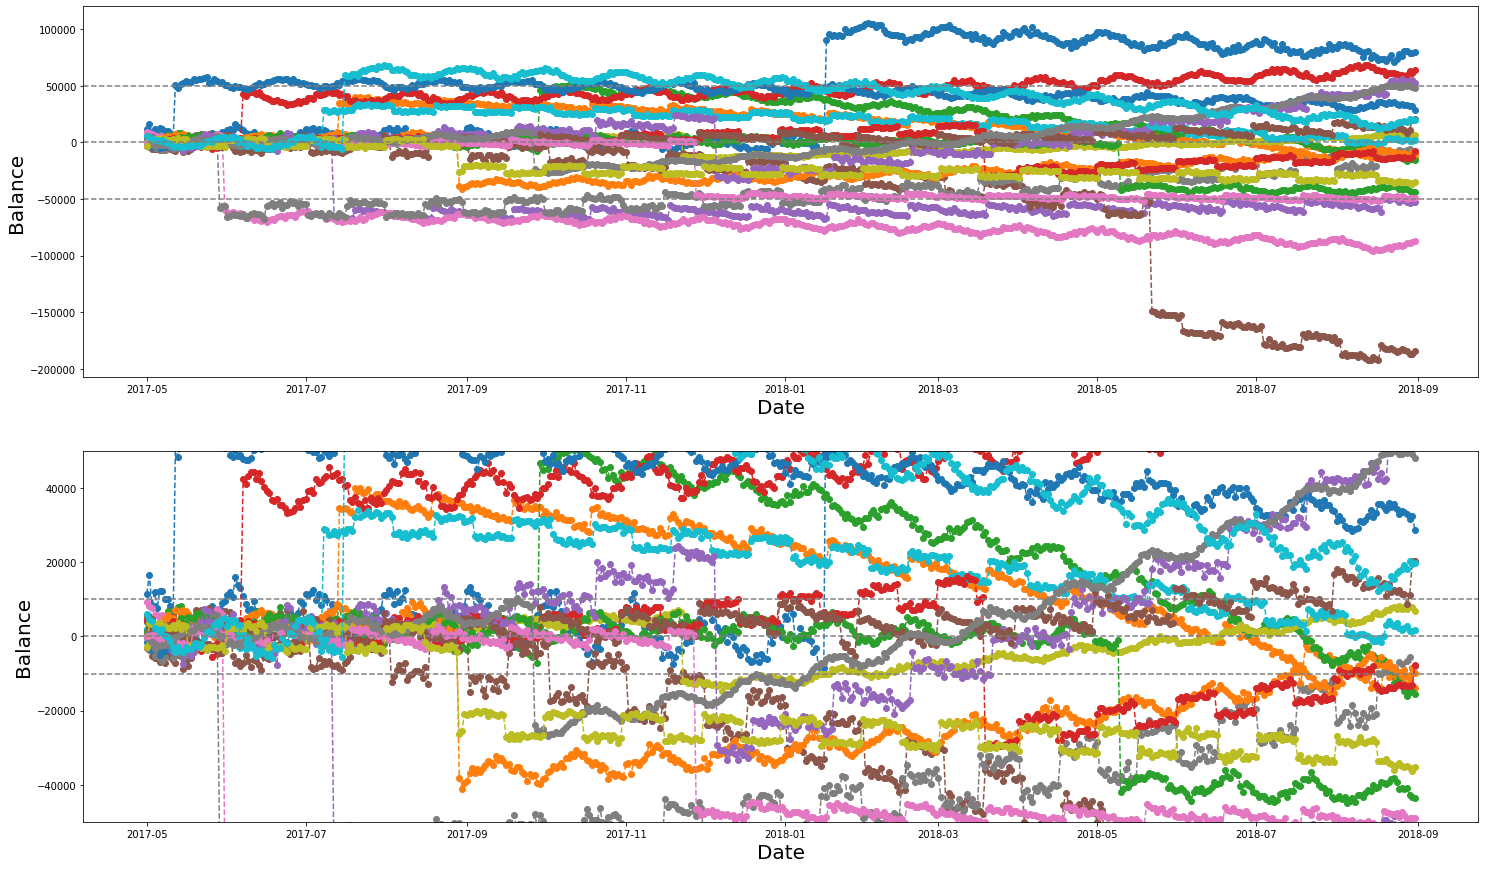

In [4]:
# ==================================
# Simple display of some time series
# ==================================

fig = plt.figure(1, (25, 15))

columns = ts_all.columns[101:121]

ax = plt.subplot(2, 1, 1)
for column in columns:
    plt.plot(ts_all.iloc[:, 0], ts_all[column], 'o--')
# ax.set_ylim([-1e5,1e5])
ax.axhline(y=0., color='gray', linestyle='--')
ax.axhline(y=-5e4, color='gray', linestyle='--')
ax.axhline(y=5e4, color='gray', linestyle='--')
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Balance', fontsize=20)

ax = plt.subplot(2, 1, 2)
for column in columns:
    plt.plot(ts_all.iloc[:, 0], ts_all[column], 'o--')
ax.set_ylim([-5e4, 5e4])
ax.axhline(y=0., color='gray', linestyle='--')
ax.axhline(y=-1e4, color='gray', linestyle='--')
ax.axhline(y=1e4, color='gray', linestyle='--')
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Balance', fontsize=20)

plt.show()

In [5]:
# ======================
# Time window definition (for training and testing sets)
# ======================

filter_X = (
    ts_all['date'] >= start_date_train) & (
        ts_all['date'] <= end_date_train)
filter_y = (
    ts_all['date'] >= start_date_test) & (
        ts_all['date'] <= end_date_test)

time_X = ts_all.loc[filter_X, ts_all.columns[0:1]]
time_y = ts_all.loc[filter_y, ts_all.columns[0:1]]

index_X = ts_all.loc[filter_X, 'date']  # same as time_X !!!
index_y = ts_all.loc[filter_y, 'date']  # same as time_y !!!

N_days_X = time_X.shape[0]
N_days_y = time_y.shape[0]
print(N_days_X, N_days_y)

365 92


In [6]:
# ==================================================================================
# Detrending: Creation of detrended and trends dataframes with same format as ts_all   
# ==================================================================================

def long_term_detrending_function(ts_all):
    
    ts_all_detrended = ts_all.copy()    
    ts_all_trends    = ts_all.copy()
    ts_all_detrended.iloc[:,1:] = 0.
    ts_all_trends.iloc[:,1:] = 0.

    for column in ts_all.columns[1:]:
        #decomposition = sm.tsa.seasonal_decompose(ts_all.loc[filter_X,column].values, model='additive', freq=30, extrapolate_trend=1)
        #ts_all_detrended.loc[filter_X,column] = ts_all.loc[filter_X,column].values - decomposition.trend
        #ts_all_trends.loc[filter_X,column] = decomposition.trend

        decomposition = sm.tsa.seasonal_decompose(ts_all[column].values, model='additive', freq=30, extrapolate_trend=1)   
        ts_all_detrended[column] = ts_all[column].values - decomposition.trend
        ts_all_trends[column] = decomposition.trend    

    # Building of slopes and extrapolated trends. We will need the df with time index
    ts_all.set_index('date',inplace=True)
    ts_all_trends.set_index('date',inplace=True)
    ts_all_detrended.set_index('date',inplace=True)

    slopes = ts_all.copy()
    extrapolated_trend = ts_all.iloc[N_days_X:N_days_X+N_days_y].copy()
    slopes.iloc[:,:] = 0.
    extrapolated_trend.iloc[:,:] = 0.

    for column in ts_all.columns: 
        slopes[column] = np.gradient(ts_all_trends[column].values)
        extrapolated_trend[column] = nn_lib.extrapolate_trend(ts_all_trends.iloc[:N_days_X,column],slopes.iloc[:N_days_X,column],N_days_y)

    # Reseting index back
    ts_all.reset_index(inplace=True)
    ts_all_trends.reset_index(inplace=True)
    ts_all_detrended.reset_index(inplace=True)
    slopes.reset_index(inplace=True)
    extrapolated_trend.reset_index(inplace=True) 
    
    return ts_all_detrended, ts_all_trends, slopes, extrapolated_trend

detrending_choice = 1

if detrending_choice == 1: #if detrending
    ts_all_detrended, ts_all_trends, slopes, extrapolated_trend = long_term_detrending_function(ts_all)
    ts = ts_all_detrended.copy() 
if detrending_choice == 0: # if no detrending
    ts = ts_all.copy()

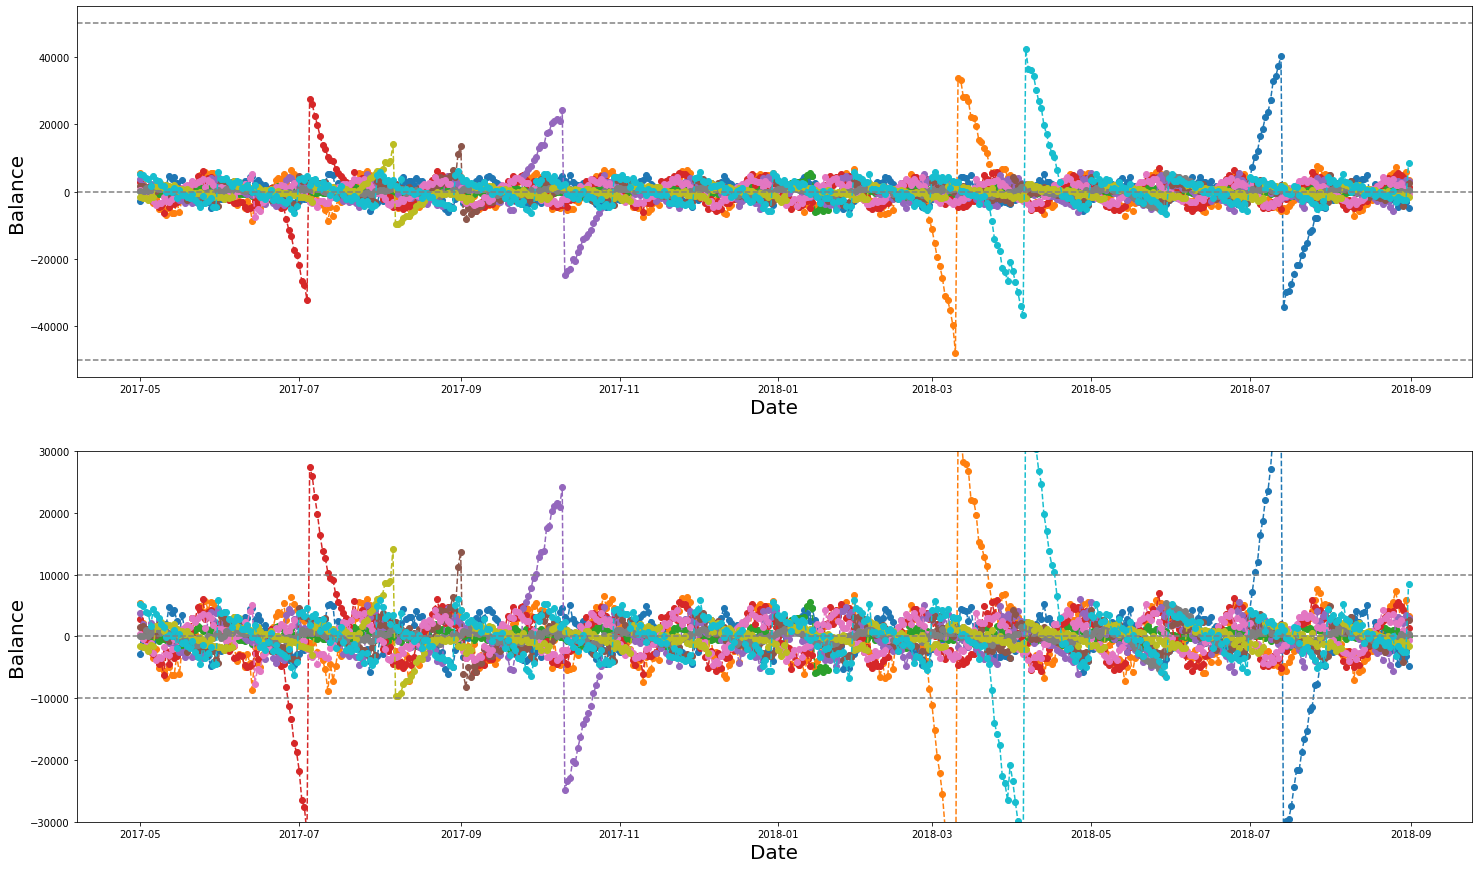

In [7]:
# In case we want to check the detrending    
fig=plt.figure(1,(25,15))
columns = ts.columns[1000:1010]

ax = plt.subplot(2,1,1)
for column in columns:
    plt.plot(ts.iloc[:,0],ts[column],'o--')
#ax.set_ylim([-1e5,1e5]) 
ax.axhline(y=0., color='gray', linestyle='--')
ax.axhline(y=-5e4, color='gray', linestyle='--')
ax.axhline(y=5e4, color='gray', linestyle='--')
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Balance',fontsize=20)

ax = plt.subplot(2,1,2)
for column in columns:
    plt.plot(ts.iloc[:,0],ts[column],'o--')
ax.set_ylim([-3e4,3e4]) 
ax.axhline(y=0., color='gray', linestyle='--')
ax.axhline(y=-1e4, color='gray', linestyle='--')
ax.axhline(y=1e4, color='gray', linestyle='--')
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Balance',fontsize=20)

plt.show()
plt.close() 

In [8]:
# =================
# Data for training
# =================

N_samples = 5000 #180000  # 20000

X = ts.loc[filter_X, ts.columns[1:1 + N_samples]].astype(float).values.T
y = ts.loc[filter_y, ts.columns[1:1 + N_samples]].astype(float).values.T

In [9]:
# ====================
# Data to be predicted
# ====================

N_samples_pred = 1000 #10000

# here validation data with detrended data
X_val = ts.loc[filter_X, ts.columns[1 + N_samples:1 + N_samples + N_samples_pred]].astype(float).values.T
y_val = ts.loc[filter_y, ts.columns[1 + N_samples:1 + N_samples + N_samples_pred]].astype(float).values.T

# here validation data with original data
X_val_original = ts.loc[filter_X, ts.columns[1 + N_samples:1 +
                                                 N_samples +
                                                 N_samples_pred]].astype(float).values.T
y_val_original = ts.loc[filter_y, ts.columns[1 + N_samples:1 +
                                                 N_samples +
                                                 N_samples_pred]].astype(float).values.T

In [10]:
# ==========================
# Data scaling and reshaping
# ==========================

# Data need to be scaled, this is an important step in Deep Learning as it allows a
# safer/faster convergence during model training.
# Here we train a scaler on each "X" part of the time series, and then transform both
# "X" and "y" parts.
# Also, the dataset has to be reshaped in Keras format, [samples, timesteps, features],
# where samples is the dimension of samples, timesteps is the length of the time series,
# and features is the number of time series per sample, here 1, as we have only one
# time series per sample.

imp.reload(nn_lib)

# The scaling is fitted on X, then we can transform X and y
X_ready, y_ready, scalers_list = nn_lib.scale_data(X,
                                                   y,
                                                   N_samples,
                                                   N_days_X,
                                                   N_days_y,
                                                   scale_type=2)

# same for validation data # ONE SCALER PER TIME SERIES!!!
X_val_ready, y_val_ready, scalers_val_list = nn_lib.scale_data(X_val,
                                                               y_val,
                                                               N_samples_pred,
                                                               N_days_X,
                                                               N_days_y,
                                                               scale_type=2)

# Re-shaping in the Keras shape, hence from [samples, timesteps] into
# [samples, timesteps, features]
X_ready = X_ready.reshape(N_samples, N_days_X, 1)
y_ready = y_ready.reshape(N_samples, N_days_y, 1)

X_val_ready = X_val_ready.reshape(N_samples_pred, N_days_X, 1)
y_val_ready = y_val_ready.reshape(N_samples_pred, N_days_y, 1)

# Sanity check
X_ready = np.nan_to_num(X_ready)
y_ready = np.nan_to_num(y_ready)

X_val_ready = np.nan_to_num(X_val_ready)
y_val_ready = np.nan_to_num(y_val_ready)

# IF CNN
y_ready_cnn = y_ready.reshape((y_ready.shape[0], y_ready.shape[1]))
y_val_ready_cnn = y_val_ready.reshape((y_val_ready.shape[0], y_val_ready.shape[1])) #in case if necessary

y_ready_cnn.shape, y_val_ready_cnn.shape

((5000, 92), (1000, 92))

In [23]:
# ==========================
# MODEL DEFINITION AND TRAIN
# ==========================

try:
    del model
except BaseException:
    pass
K.clear_session()

#tf.enable_eager_execution()
#tf.executing_eagerly()

#tf.reset_default_graph()
tf.keras.backend.clear_session()
tf.logging.set_verbosity(tf.logging.INFO)


def define_autoencoder_model(N_days_X, N_days_y):

    # Composite model

    # Here I manually reduce the learning rate (original is lr=0.001)
    # opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipnorm=1.)  #with clipnorm
    # opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0,
    # clipvalue=2.)  #with clipvalue
    #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  # default Adam
    # opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #Adam with lower lr
    # opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #Adam with lower lr
    #opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    opt = tf.keras.optimizers.Adam()

    # Activation function
    activation = 'tanh'  # 'relu'

    '''
    # Weights initialization scheme
    ini = 'glorot_uniform'  # default
    #ini = RandomUniform(minval=-0.15, maxval=0.15, seed=None)

    # Dropout definition
    dropout = 0.0  # 0.2
    recurrent_dropout = 0.0    

    # Regularizer
    reg = L1L2(l1=0.00, l2=0.00)  # L1L2(l1=0.001, l2=0.001) 
    '''

    '''
    # ENCODER
    visible  = Input(shape=(N_days_X,1))
    encoder  = LSTM(30, 
                    activation=activation,
                    dropout=dropout,
                    recurrent_dropout=recurrent_dropout,
                    kernel_initializer=ini, 
                    kernel_regularizer=reg)(visible)
    #encoder = BatchNormalization()(encoder) #NAIVE BATCH NORMALIZATION
    # RECONSTRUCTION DECODER
    decoder1 = RepeatVector(N_days_X)(encoder)
    decoder1 = LSTM(30, 
                    activation=activation,
                    dropout=dropout,
                    recurrent_dropout=recurrent_dropout,
                    kernel_initializer=ini, 
                    kernel_regularizer=reg, 
                    return_sequences=True)(decoder1)
    #decoder1 = BatchNormalization()(decoder1) #NAIVE BATCH NORMALIZATION
    decoder1 = TimeDistributed(Dense(1))(decoder1)
    # PREDICTION DECODER
    decoder2 = RepeatVector(N_days_y)(encoder)
    decoder2 = LSTM(30, 
                    activation=activation,
                    dropout=dropout,
                    recurrent_dropout=recurrent_dropout,
                    kernel_initializer=ini, 
                    kernel_regularizer=reg, 
                    return_sequences=True)(decoder2)
    #decoder2 = BatchNormalization()(decoder2) #NAIVE BATCH NORMALIZATION
    decoder2 = TimeDistributed(Dense(1))(decoder2)
    # tie it together
    model = Model(inputs=visible, outputs=[decoder1, decoder2]) 
    '''
    
    #pure keras
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(N_days_X, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(N_days_y))
    
    #pure Keras, no Sequential API
    #visible = Input(shape=(N_days_X,1))
    #x = Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(N_days_X, 1))(visible)
    #x = MaxPooling1D(pool_size=2)(x)
    #x = Flatten()(x)
    #x = Dense(50, activation='relu')(x)
    #x = Dense(N_days_y)(x)
    #model = Model(inputs=visible, outputs=x)
        
    #tf.keras
    #model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(N_days_X, 1))) #tf.keras.activations.relu OR tf.nn.relu
    ##model.add(tf.keras.layers.Dropout(0.5))
    #model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    #model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.Dense(50, activation='relu')) #tf.keras.activations.relu OR tf.nn.relu
    #model.add(tf.keras.layers.Dense(N_days_y)) 
    
    #tf.keras, no Sequential API    
    #visible = tf.keras.layers.Input(shape=(N_days_X, 1, ))
    #x = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
    #x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    #x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.Dense(50, activation='relu')(x)
    #x = tf.keras.layers.Dense(N_days_y)(x)
    #model = tf.keras.models.Model(inputs=visible, outputs=x)
    
        
    # A bit more deep: 2 layers and dropout added
    #model = Sequential()
    #model.add(
    #    Conv1D(
    #        filters=64,
    #        kernel_size=2,
    #        activation='relu',
    #        input_shape=(
    #            N_days_X,
    #            1)))
    #model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    ##model.add(Dropout(0.5))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Flatten())
    #model.add(Dense(50, activation='relu'))
    #model.add(Dense(N_days_y))

    # Model compilation
    model.compile(optimizer='adam', loss='mae')  # ,metrics=['mse'])
    # model.compile(optimizer=opt , loss= 'mse')#,metrics=['mse'])
    #model.compile(optimizer='adam' , loss= losses.mean_absolute_percentage_error,metrics=['mae','mse'])
    #model.compile(optimizer='adam' , loss= losses.mean_squared_logarithmic_error)
    #plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

    return model

def train_model(X_ready, y_ready, name=''):
    # Callbacks definition: Set callback functions to early stop training and
    # save the best model so far
    callbacks = [EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min'),
                 ModelCheckpoint(filepath='model-{epoch:02d}-{val_loss:.4f}.h5',
                                 monitor='val_loss',
                                 save_best_only=True,  # False,
                                 save_weights_only=False,
                                 mode='auto',
                                 verbose=1),
                 CSVLogger('training_{0}.log'.format(name),
                           separator=',',
                           append=True),
                           #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
                           TerminateOnNaN()
                ]

    # Model training
    history = model.fit(X_ready,               # Features
                        #[X_ready,y_ready],    # CASE AUTOENCODER Target vector
                        y_ready ,              # CASE CNN Target vector  
                        validation_split=0.20, # size of validation fraction, compared to total dataset
                        batch_size=200,        # Number of observations per batch
                        epochs=50,             # Number of epochs
                        callbacks=callbacks,   # Early stopping and saving of best model so far
                        verbose=1)    

    return model 

model = define_autoencoder_model(N_days_X, N_days_y)

W0831 15:57:20.383102 140400142006080 deprecation_wrapper.py:119] From /home/philippe/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 15:57:20.545116 140400142006080 deprecation_wrapper.py:119] From /home/philippe/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0831 15:57:20.588187 140400142006080 deprecation_wrapper.py:119] From /home/philippe/anaconda3/envs/tf/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [24]:
training_option_choice = 1


if training_option_choice == 1:
    # OPTION 1: training of one model
    i = 1
    model = define_autoencoder_model(N_days_X, N_days_y)
    model = train_model(X_ready, y_ready_cnn, name='run_{0}'.format(str(i)))

if training_option_choice == 2:
    # OPTION 2: training of a group of models (can be useful to launch many runs. Models can have different
    # convergence speeds/values, also in case where loss often ends up in
    # NaNs...)

    for i in range(5):

        try:  # if a run crashes, start next one
            model = define_autoencoder_model(N_days_X, N_days_y)
            model = train_model(X_ready, y_ready_cnn, name='run{0}'.format(str(i)))
        except BaseException:
            print()
            print()
            print()
            pass

        try:
            del model
        except BaseException:
            pass

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 378us/step - loss: 0.7019 - val_loss: 0.6464

Epoch 00001: val_loss improved from inf to 0.64644, saving model to model-01-0.6464.h5
Epoch 2/50
4000/4000 [==============================] - 1s 299us/step - loss: 0.5795 - val_loss: 0.5532

Epoch 00002: val_loss improved from 0.64644 to 0.55320, saving model to model-02-0.5532.h5
Epoch 3/50
4000/4000 [==============================] - 1s 310us/step - loss: 0.5106 - val_loss: 0.5148

Epoch 00003: val_loss improved from 0.55320 to 0.51476, saving model to model-03-0.5148.h5
Epoch 4/50
4000/4000 [==============================] - 1s 314us/step - loss: 0.4862 - val_loss: 0.5054

Epoch 00004: val_loss improved from 0.51476 to 0.50544, saving model to model-04-0.5054.h5
Epoch 5/50
4000/4000 [==============================] - 1s 307us/step - loss: 0.4747 - val_loss: 0.4942

Epoch 00005: val_loss improved from 0.50544 to 0.49425, saving mode

4000/4000 [==============================] - 1s 294us/step - loss: 0.4114 - val_loss: 0.4484

Epoch 00044: val_loss improved from 0.44871 to 0.44837, saving model to model-44-0.4484.h5
Epoch 45/50
4000/4000 [==============================] - 1s 301us/step - loss: 0.4112 - val_loss: 0.4490

Epoch 00045: val_loss did not improve from 0.44837
Epoch 46/50
4000/4000 [==============================] - 1s 299us/step - loss: 0.4113 - val_loss: 0.4484

Epoch 00046: val_loss did not improve from 0.44837
Epoch 47/50
4000/4000 [==============================] - 1s 296us/step - loss: 0.4106 - val_loss: 0.4485

Epoch 00047: val_loss did not improve from 0.44837
Epoch 48/50
4000/4000 [==============================] - 1s 299us/step - loss: 0.4098 - val_loss: 0.4477

Epoch 00048: val_loss improved from 0.44837 to 0.44771, saving model to model-48-0.4477.h5
Epoch 49/50
4000/4000 [==============================] - 1s 306us/step - loss: 0.4092 - val_loss: 0.4474

Epoch 00049: val_loss improved from 0.447

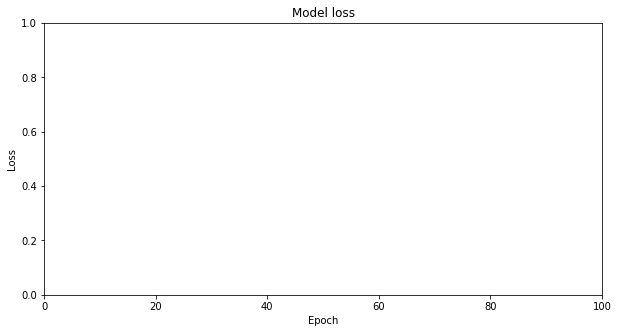

In [13]:
# ======================================
# Plot training & validation loss values
# ======================================
fig=plt.figure(1,(10,5))
ax = plt.subplot(111)

color=['blue','red','green','gray','yellow','orange','pink','cyan','violet','brown']
for i in range(0,10):
    try: #if a run crashes, start next one       
        run = pd.read_csv('training_run{0}.log'.format(str(i)),sep=',')
        #run = pd.read_csv('training_run_{0}.log'.format(str(i)),sep=',')
        ax.plot(run['epoch'],run['loss'],'-')#,color=color[i])
        ax.plot(run['epoch'],run['val_loss'],'--')#,color=color[i])          
    except:
        print()
        print()
        print()        
        pass
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
#ax.set_ylim([0.8,2.5])
ax.set_xlim([0,100])
#plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [25]:
# ================
# MODEL RE-LOADING
# ================

try:
    del model    
except:
    pass
K.clear_session()

#model = load_model('model-03-1.6438.h5')
#model = load_model('model-20-1.1521.h5') #model-01-1.4800.h5

#model = load_model('model-152-1.3665.h5')
#model = load_model('model-03-0.6729.h5')
#model = load_model('model-63-0.5904.h5')
#model = load_model('model-80-0.4362.h5')

#model = load_model('model-500-0.7700.h5')

#model = load_model('model-42-0.9444.h5')
#model = load_model('model-151-0.9713.h5')

#model = load_model('model-194-1.3537.h5')

#model = load_model('model-93-1.1770.h5')

#model = load_model('model-48-0.9215.h5')

model = load_model('model-49-0.4474.h5')


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 364, 64)           192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 182, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11648)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                582450    
_________________________________________________________________
dense_4 (Dense)              (None, 92)                4692      
Total params: 587,334
Trainable params: 587,334
Non-trainable params: 0
_________________________________________________________________


In [17]:
# ====================================
# TRAINING OF SPECIFIC RE-LOADED MODEL
# ====================================

callbacks = [EarlyStopping(monitor='val_loss', patience=3000, verbose=0, mode='min'),
             ModelCheckpoint(filepath='model-{epoch:02d}-{val_loss:.4f}.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=False, 
                             mode='auto', 
                             verbose=1),
             CSVLogger('training_{0}.log'.format('follow_up'), separator=',', append=True),
             #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
             TerminateOnNaN()]

history = model.fit(X_ready,               # Features
                    [X_ready,y_ready],     # Target vector
                    validation_split=0.20, # size of validation fraction, compared to total dataset
                    batch_size=100,        # Number of observations per batch
                    epochs=1000,          # Number of epochs (you can stop it manually)
                    callbacks=callbacks,   # Early stopping and saving of best model so far
                    verbose=1)

Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 8s 3ms/step - loss: 1.3809 - time_distributed_1_loss: 0.3543 - time_distributed_2_loss: 1.0266 - val_loss: 1.2386 - val_time_distributed_1_loss: 0.3394 - val_time_distributed_2_loss: 0.8991

Epoch 00001: val_loss improved from inf to 1.23855, saving model to model-01-1.2386.h5
Epoch 2/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3767 - time_distributed_1_loss: 0.3593 - time_distributed_2_loss: 1.0174 - val_loss: 1.2668 - val_time_distributed_1_loss: 0.3619 - val_time_distributed_2_loss: 0.9049

Epoch 00002: val_loss did not improve from 1.23855
Epoch 3/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3684 - time_distributed_1_loss: 0.3600 - time_distributed_2_loss: 1.0084 - val_loss: 1.2252 - val_time_distributed_1_loss: 0.3411 - val_time_distributed_2_loss: 0.8841

Epoch 00003: val_loss improved from 1.23855 to 1.22516, saving model

2400/2400 [==============================] - 7s 3ms/step - loss: 1.3355 - time_distributed_1_loss: 0.3459 - time_distributed_2_loss: 0.9896 - val_loss: 1.2139 - val_time_distributed_1_loss: 0.3322 - val_time_distributed_2_loss: 0.8817

Epoch 00027: val_loss did not improve from 1.19801
Epoch 28/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3443 - time_distributed_1_loss: 0.3507 - time_distributed_2_loss: 0.9936 - val_loss: 1.2117 - val_time_distributed_1_loss: 0.3297 - val_time_distributed_2_loss: 0.8820

Epoch 00028: val_loss did not improve from 1.19801
Epoch 29/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3223 - time_distributed_1_loss: 0.3383 - time_distributed_2_loss: 0.9840 - val_loss: 1.2034 - val_time_distributed_1_loss: 0.3245 - val_time_distributed_2_loss: 0.8789

Epoch 00029: val_loss did not improve from 1.19801
Epoch 30/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3239 - time_distributed_1_loss

2400/2400 [==============================] - 7s 3ms/step - loss: 1.3012 - time_distributed_1_loss: 0.3280 - time_distributed_2_loss: 0.9732 - val_loss: 1.1927 - val_time_distributed_1_loss: 0.3115 - val_time_distributed_2_loss: 0.8813

Epoch 00054: val_loss improved from 1.19583 to 1.19274, saving model to model-54-1.1927.h5
Epoch 55/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.2966 - time_distributed_1_loss: 0.3248 - time_distributed_2_loss: 0.9719 - val_loss: 1.2168 - val_time_distributed_1_loss: 0.3307 - val_time_distributed_2_loss: 0.8860

Epoch 00055: val_loss did not improve from 1.19274
Epoch 56/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3141 - time_distributed_1_loss: 0.3328 - time_distributed_2_loss: 0.9813 - val_loss: 1.2271 - val_time_distributed_1_loss: 0.3268 - val_time_distributed_2_loss: 0.9003

Epoch 00056: val_loss did not improve from 1.19274
Epoch 57/1000
2400/2400 [==============================] - 7s 3ms/step 

2400/2400 [==============================] - 7s 3ms/step - loss: 1.2876 - time_distributed_1_loss: 0.3209 - time_distributed_2_loss: 0.9667 - val_loss: 1.1881 - val_time_distributed_1_loss: 0.3077 - val_time_distributed_2_loss: 0.8804

Epoch 00081: val_loss improved from 1.19015 to 1.18807, saving model to model-81-1.1881.h5
Epoch 82/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.2877 - time_distributed_1_loss: 0.3209 - time_distributed_2_loss: 0.9669 - val_loss: 1.1872 - val_time_distributed_1_loss: 0.3054 - val_time_distributed_2_loss: 0.8818

Epoch 00082: val_loss improved from 1.18807 to 1.18719, saving model to model-82-1.1872.h5
Epoch 83/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.2816 - time_distributed_1_loss: 0.3172 - time_distributed_2_loss: 0.9644 - val_loss: 1.1957 - val_time_distributed_1_loss: 0.3059 - val_time_distributed_2_loss: 0.8899

Epoch 00083: val_loss did not improve from 1.18719
Epoch 84/1000
2400/2400 [======


Epoch 00107: val_loss did not improve from 1.17699
Epoch 108/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.9903 - time_distributed_1_loss: 0.6700 - time_distributed_2_loss: 1.3203 - val_loss: 1.6774 - val_time_distributed_1_loss: 0.5010 - val_time_distributed_2_loss: 1.1764

Epoch 00108: val_loss did not improve from 1.17699
Epoch 109/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.8242 - time_distributed_1_loss: 0.5533 - time_distributed_2_loss: 1.2709 - val_loss: 1.7909 - val_time_distributed_1_loss: 0.6250 - val_time_distributed_2_loss: 1.1659

Epoch 00109: val_loss did not improve from 1.17699
Epoch 110/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.8520 - time_distributed_1_loss: 0.5919 - time_distributed_2_loss: 1.2601 - val_loss: 1.6467 - val_time_distributed_1_loss: 0.5334 - val_time_distributed_2_loss: 1.1134

Epoch 00110: val_loss did not improve from 1.17699
Epoch 111/1000
2400/2400 [================

2400/2400 [==============================] - 8s 3ms/step - loss: 1.6225 - time_distributed_1_loss: 0.4925 - time_distributed_2_loss: 1.1300 - val_loss: 1.5150 - val_time_distributed_1_loss: 0.4835 - val_time_distributed_2_loss: 1.0315

Epoch 00135: val_loss did not improve from 1.17699
Epoch 136/1000
2400/2400 [==============================] - 8s 3ms/step - loss: 1.6159 - time_distributed_1_loss: 0.4894 - time_distributed_2_loss: 1.1265 - val_loss: 1.5138 - val_time_distributed_1_loss: 0.4856 - val_time_distributed_2_loss: 1.0282

Epoch 00136: val_loss did not improve from 1.17699
Epoch 137/1000
2400/2400 [==============================] - 8s 3ms/step - loss: 1.6117 - time_distributed_1_loss: 0.4878 - time_distributed_2_loss: 1.1239 - val_loss: 1.4955 - val_time_distributed_1_loss: 0.4815 - val_time_distributed_2_loss: 1.0140

Epoch 00137: val_loss did not improve from 1.17699
Epoch 138/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.6099 - time_distributed_1_l

2400/2400 [==============================] - 7s 3ms/step - loss: 1.4453 - time_distributed_1_loss: 0.4166 - time_distributed_2_loss: 1.0288 - val_loss: 1.3697 - val_time_distributed_1_loss: 0.4125 - val_time_distributed_2_loss: 0.9572

Epoch 00189: val_loss did not improve from 1.17699
Epoch 190/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.4445 - time_distributed_1_loss: 0.4144 - time_distributed_2_loss: 1.0300 - val_loss: 1.3723 - val_time_distributed_1_loss: 0.4152 - val_time_distributed_2_loss: 0.9572

Epoch 00190: val_loss did not improve from 1.17699
Epoch 191/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.4404 - time_distributed_1_loss: 0.4138 - time_distributed_2_loss: 1.0267 - val_loss: 1.3792 - val_time_distributed_1_loss: 0.4154 - val_time_distributed_2_loss: 0.9637

Epoch 00191: val_loss did not improve from 1.17699
Epoch 192/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.4371 - time_distributed_1_l

2400/2400 [==============================] - 7s 3ms/step - loss: 1.3763 - time_distributed_1_loss: 0.3815 - time_distributed_2_loss: 0.9948 - val_loss: 1.3440 - val_time_distributed_1_loss: 0.3807 - val_time_distributed_2_loss: 0.9632

Epoch 00243: val_loss did not improve from 1.17699
Epoch 244/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3840 - time_distributed_1_loss: 0.3895 - time_distributed_2_loss: 0.9945 - val_loss: 1.3304 - val_time_distributed_1_loss: 0.3871 - val_time_distributed_2_loss: 0.9433

Epoch 00244: val_loss did not improve from 1.17699
Epoch 245/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3734 - time_distributed_1_loss: 0.3836 - time_distributed_2_loss: 0.9899 - val_loss: 1.3293 - val_time_distributed_1_loss: 0.3777 - val_time_distributed_2_loss: 0.9516

Epoch 00245: val_loss did not improve from 1.17699
Epoch 246/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3713 - time_distributed_1_l

2400/2400 [==============================] - 7s 3ms/step - loss: 1.3819 - time_distributed_1_loss: 0.3903 - time_distributed_2_loss: 0.9916 - val_loss: 1.3018 - val_time_distributed_1_loss: 0.3851 - val_time_distributed_2_loss: 0.9167

Epoch 00297: val_loss did not improve from 1.17699
Epoch 298/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3667 - time_distributed_1_loss: 0.3822 - time_distributed_2_loss: 0.9845 - val_loss: 1.2947 - val_time_distributed_1_loss: 0.3742 - val_time_distributed_2_loss: 0.9205

Epoch 00298: val_loss did not improve from 1.17699
Epoch 299/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3666 - time_distributed_1_loss: 0.3806 - time_distributed_2_loss: 0.9860 - val_loss: 1.3028 - val_time_distributed_1_loss: 0.3782 - val_time_distributed_2_loss: 0.9246

Epoch 00299: val_loss did not improve from 1.17699
Epoch 300/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3680 - time_distributed_1_l

2400/2400 [==============================] - 7s 3ms/step - loss: 1.3930 - time_distributed_1_loss: 0.3978 - time_distributed_2_loss: 0.9952 - val_loss: 1.3564 - val_time_distributed_1_loss: 0.4107 - val_time_distributed_2_loss: 0.9457

Epoch 00351: val_loss did not improve from 1.17699
Epoch 352/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3747 - time_distributed_1_loss: 0.3882 - time_distributed_2_loss: 0.9864 - val_loss: 1.3267 - val_time_distributed_1_loss: 0.3866 - val_time_distributed_2_loss: 0.9401

Epoch 00352: val_loss did not improve from 1.17699
Epoch 353/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.4218 - time_distributed_1_loss: 0.3936 - time_distributed_2_loss: 1.0282 - val_loss: 1.3801 - val_time_distributed_1_loss: 0.4020 - val_time_distributed_2_loss: 0.9782

Epoch 00353: val_loss did not improve from 1.17699
Epoch 354/1000
2400/2400 [==============================] - 7s 3ms/step - loss: 1.4473 - time_distributed_1_l

2400/2400 [==============================] - 8s 3ms/step - loss: 1.5681 - time_distributed_1_loss: 0.4713 - time_distributed_2_loss: 1.0968 - val_loss: 1.4957 - val_time_distributed_1_loss: 0.4658 - val_time_distributed_2_loss: 1.0299

Epoch 00405: val_loss did not improve from 1.17699
Epoch 406/1000
2400/2400 [==============================] - 8s 3ms/step - loss: 1.5490 - time_distributed_1_loss: 0.4670 - time_distributed_2_loss: 1.0820 - val_loss: 1.4345 - val_time_distributed_1_loss: 0.4515 - val_time_distributed_2_loss: 0.9830

Epoch 00406: val_loss did not improve from 1.17699
Epoch 407/1000
2400/2400 [==============================] - 8s 3ms/step - loss: 1.5282 - time_distributed_1_loss: 0.4530 - time_distributed_2_loss: 1.0752 - val_loss: 1.4126 - val_time_distributed_1_loss: 0.4449 - val_time_distributed_2_loss: 0.9677

Epoch 00407: val_loss did not improve from 1.17699
Epoch 408/1000
2400/2400 [==============================] - 8s 3ms/step - loss: 1.5016 - time_distributed_1_l

KeyboardInterrupt: 

In [27]:
# Actual prediction
y_pred = model.predict(X_val_ready, verbose=0)

# Only for multicomposite!!
#y_pred_all = y_pred.copy()
#y_pred = y_pred[1]

# De-shaping from the Keras shape to scikit-learn shape
y_pred = y_pred.reshape(N_samples_pred, N_days_y)

# Scaling BACK prediction to normal scale
y_pred = nn_lib.scale_data_back(y_pred, scalers_val_list)

# Retrending the predictions, if needed
if detrending_choice == 1:
    
    # 1. Here the extrapolation of the trend
    y_extrapolated_trend = extrapolated_trend[extrapolated_trend.columns[1+N_samples:1+N_samples+N_samples_pred]].astype(float).values.T 
    
    # 2. Retrending
    y_pred = y_pred + y_extrapolated_trend    

# Sanity check
y_pred = np.nan_to_num(y_pred)

# Building the output  #USE index_y for index building !!!
ts_pred = pd.DataFrame(y_pred.T,
                       columns=ts_all.columns[1 + N_samples:1 + N_samples + N_samples_pred],
                       index=index_y)
ts_pred.reset_index(inplace=True)

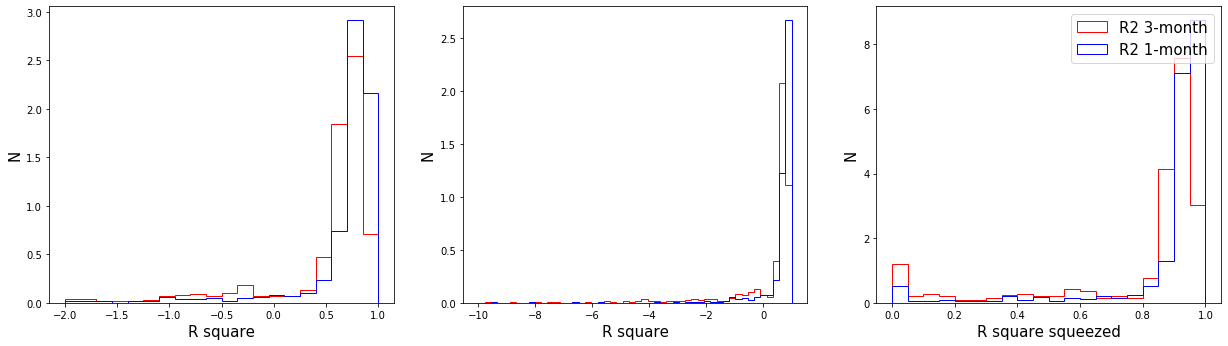

In [28]:
# =========
# R2 metric (performance measured for whole test dataset)
# =========

y_val_original = ts_all.loc[(ts_all['date'] >= start_date_test) & (
    ts_all['date'] <= end_date_test), ts_pred.columns[1:]].values.T
y_pred = ts_pred.loc[(ts_pred['date'] >= start_date_test) & (
    ts_pred['date'] <= end_date_test), ts_pred.columns[1:]].values.T

R2_array = np.zeros(N_samples_pred)
for i in range(0, N_samples_pred):
    R2_array[i] = r2_score(y_val_original[i], y_pred[i])  # .T[0]
    # print(R2_array[i])

R2_array_1month = np.zeros(N_samples_pred)
for i in range(0, N_samples_pred):
    R2_array_1month[i] = r2_score(
        y_val_original[i][0:31], y_pred[i][0:31])  # .T[0]
    # print(R2_array[i])


def sigmoid_squeezed(x):
    return (1 + np.exp(-1)) / (1 + np.exp(-x))


R2_array_squeezed = sigmoid_squeezed(R2_array)
R2_array_1month_squeezed = sigmoid_squeezed(R2_array_1month)

fig = plt.figure(1, (21, 12))

ax1 = plt.subplot(2, 3, 1)
plt.hist(R2_array,
         bins=20,
         range=[-2,
                1],
         histtype='step',
         color='red',
         label='R2 3-month',
         normed=True)
plt.hist(R2_array_1month,
         bins=20,
         range=[-2,
                1],
         histtype='step',
         color='blue',
         label='R2 1-month',
         normed=True)
ax1.set_xlabel('R square', fontsize=15)
ax1.set_ylabel('N', fontsize=15)

ax1 = plt.subplot(2, 3, 2)
plt.hist(R2_array,
         bins=50,
         range=[-10,
                1],
         histtype='step',
         color='red',
         label='R2 3-month',
         normed=True)
plt.hist(R2_array_1month,
         bins=50,
         range=[-10,
                1],
         histtype='step',
         color='blue',
         label='R2 1-month',
         normed=True)
ax1.set_xlabel('R square', fontsize=15)
ax1.set_ylabel('N', fontsize=15)

ax1 = plt.subplot(2, 3, 3)
plt.hist(
    R2_array_squeezed,
    bins=20,
    range=[
        0,
        1],
    histtype='step',
    color='red',
    label='R2 3-month',
    normed=True)
plt.hist(
    R2_array_1month_squeezed,
    bins=20,
    range=[
        0,
        1],
    histtype='step',
    color='blue',
    label='R2 1-month',
    normed=True)
ax1.set_xlabel('R square squeezed', fontsize=15)
ax1.set_ylabel('N', fontsize=15)

plt.legend(loc='upper right', fontsize=15)
plt.show()

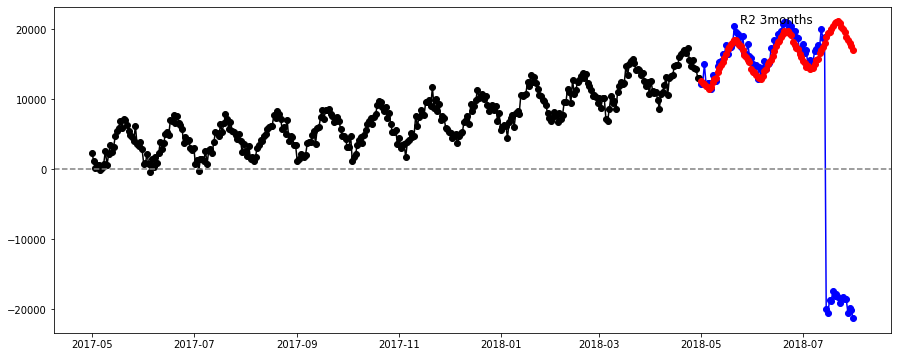

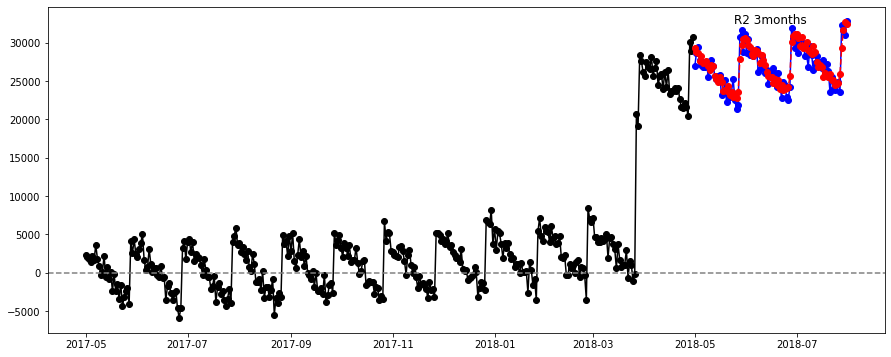

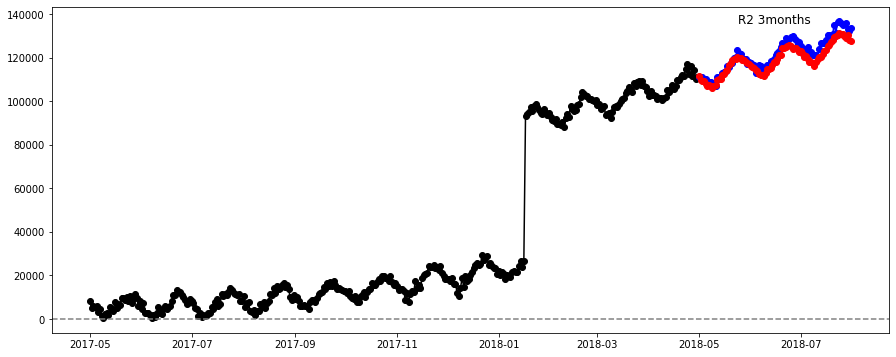

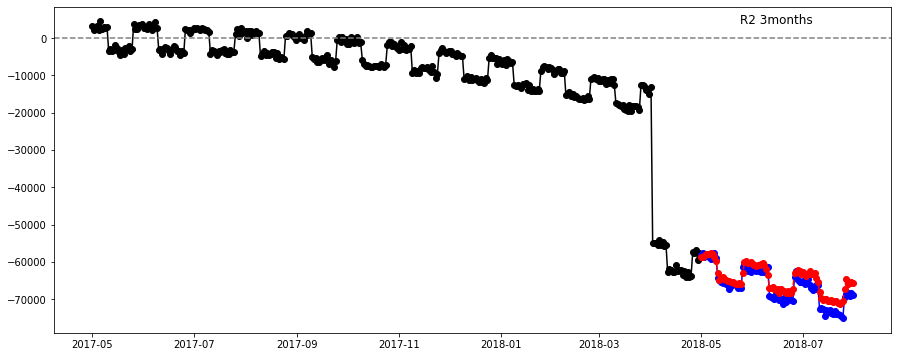

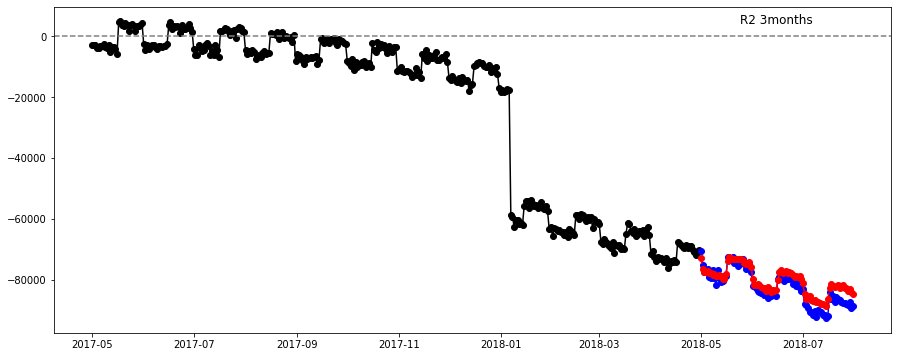

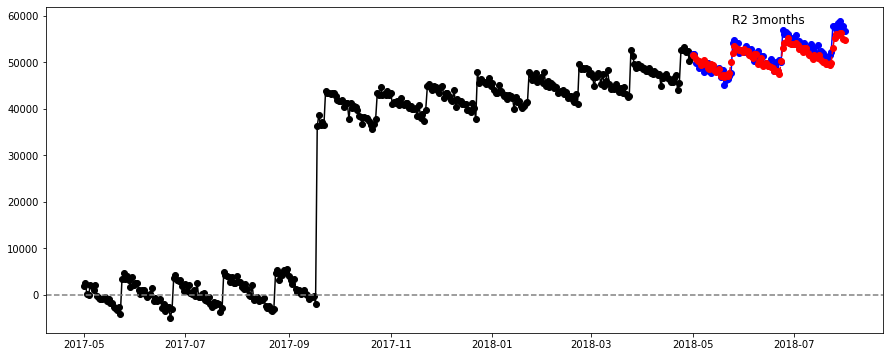

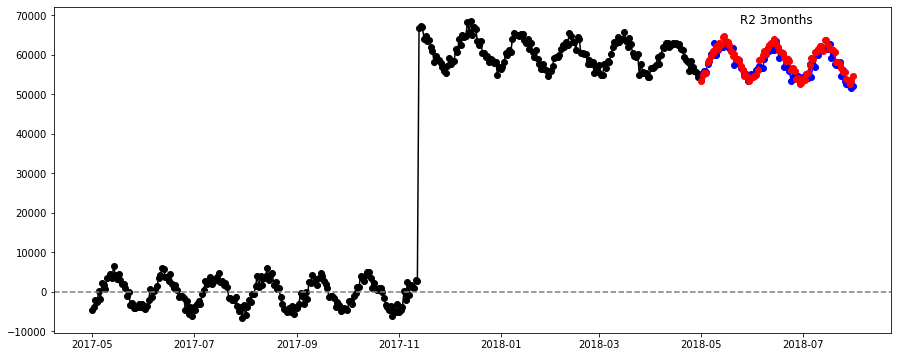

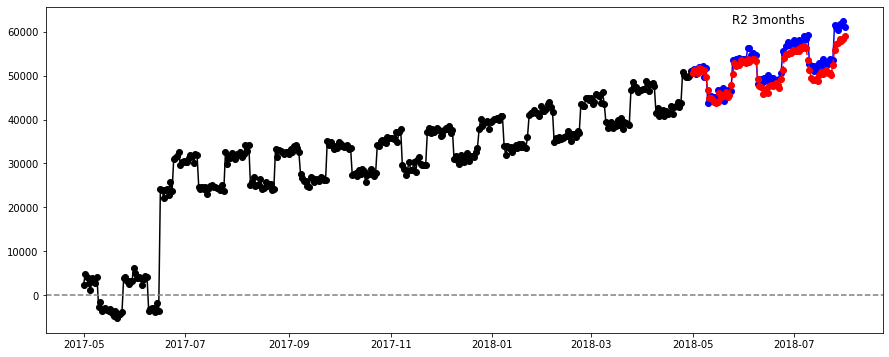

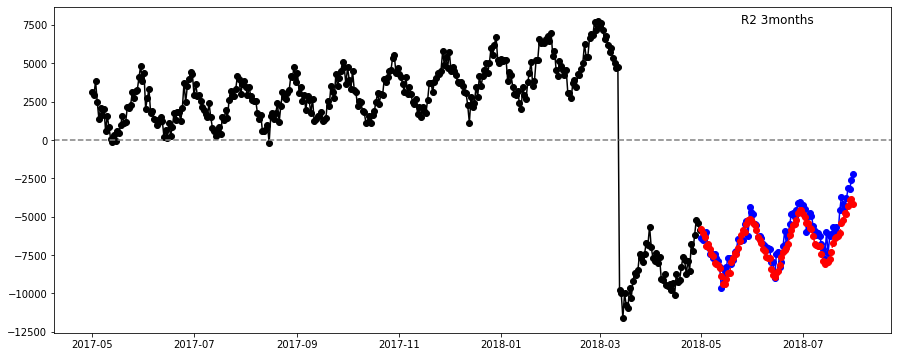

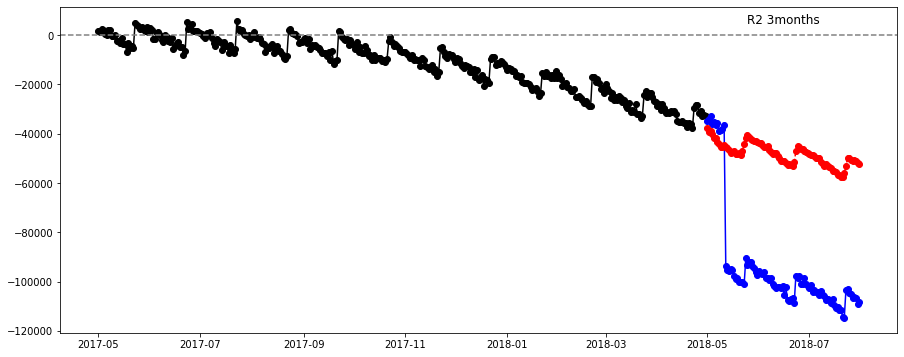

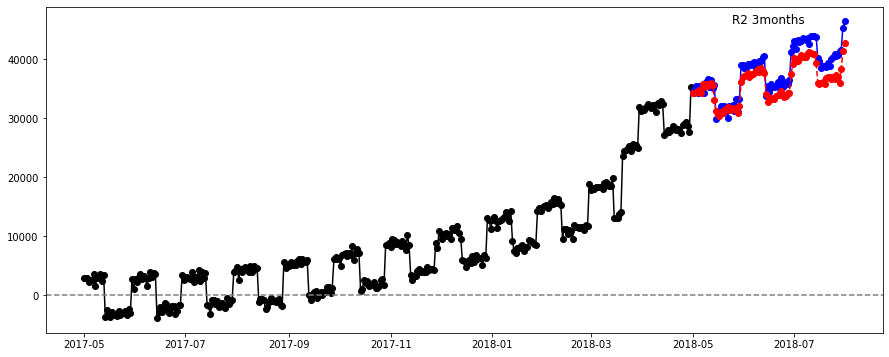

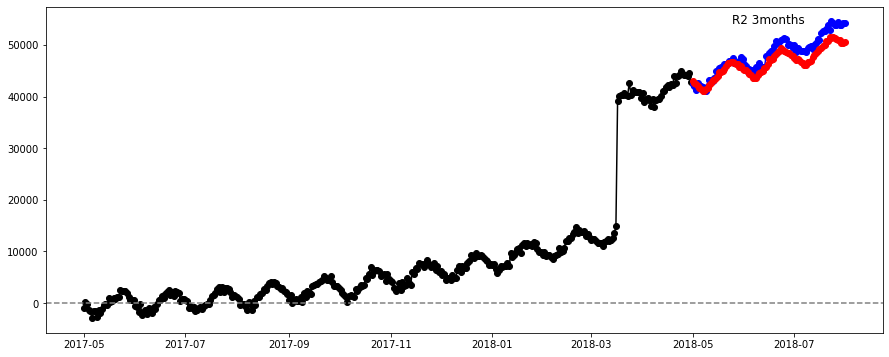

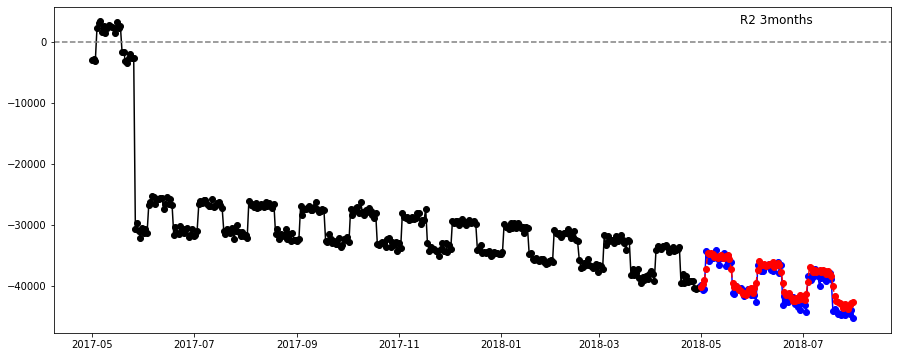

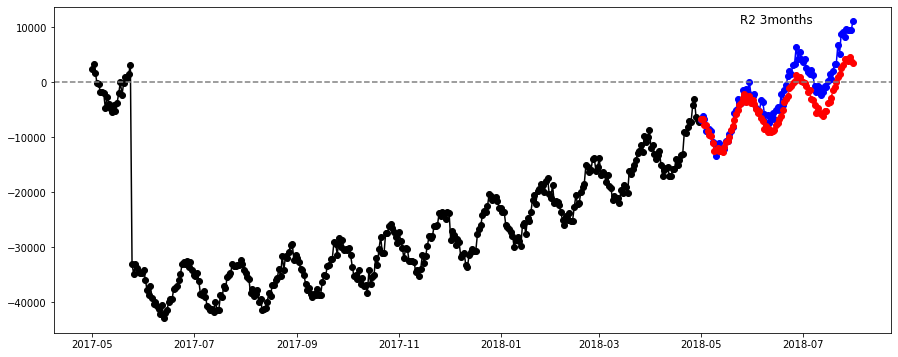

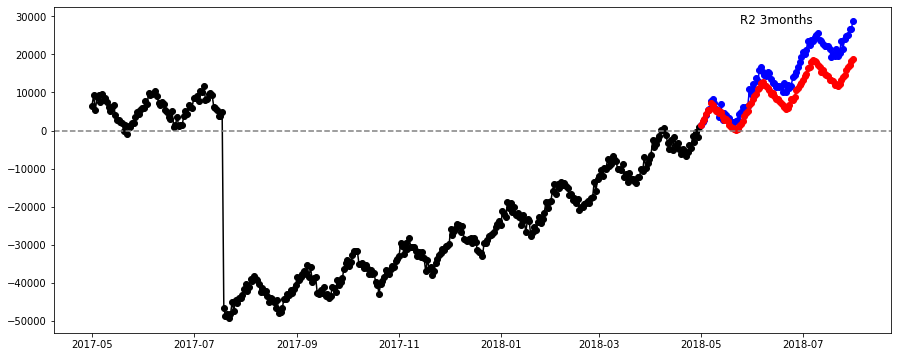

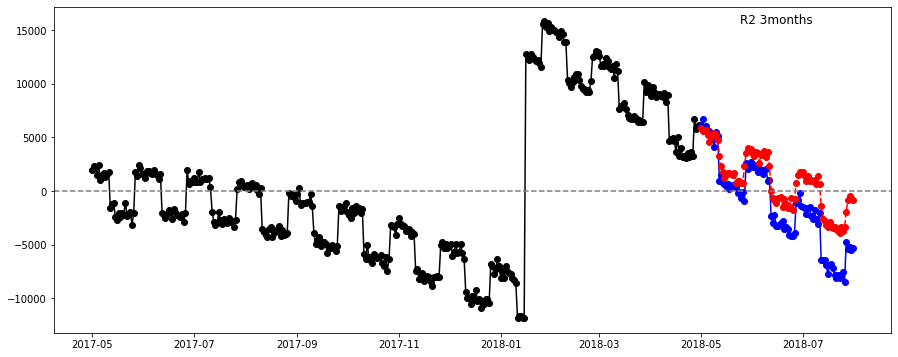

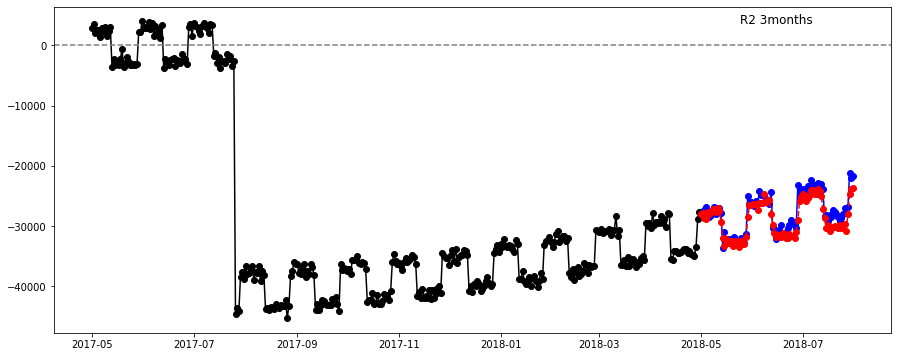

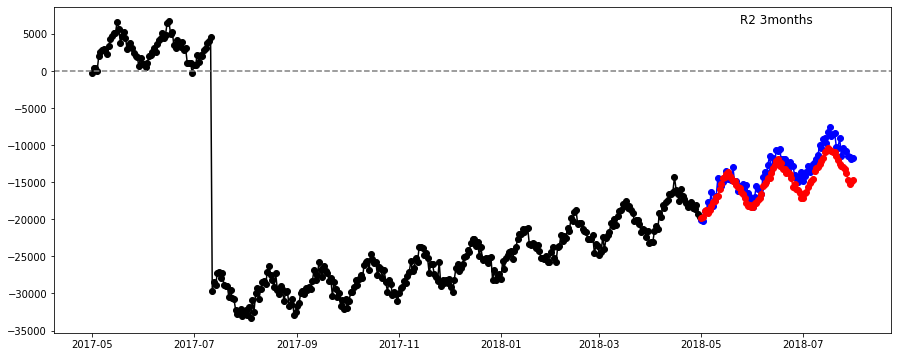

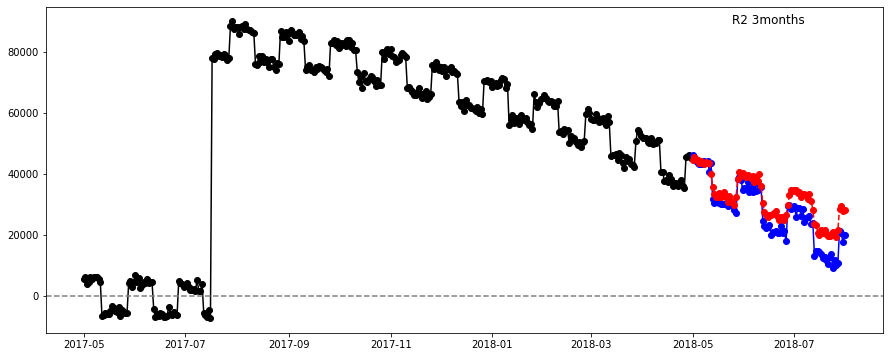

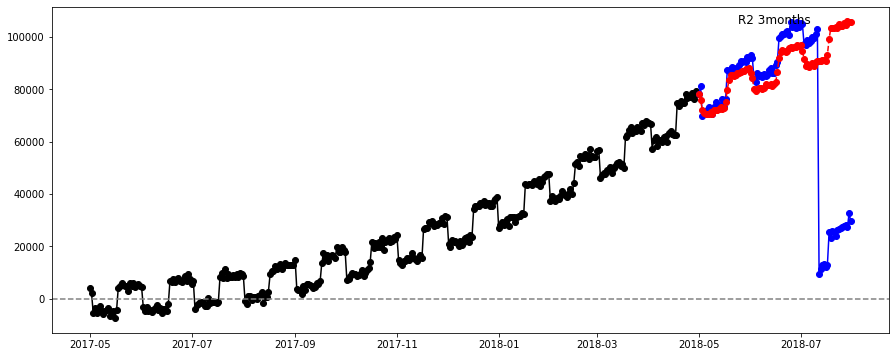

In [30]:
# COMPARISON PREDICTION VS ORIGINAL

X_val_original = ts_all.loc[filter_X, ts_all.columns[1 + N_samples:1 + N_samples + N_samples_pred]].astype(float).values.T
y_val_original = ts_all.loc[filter_y, ts_all.columns[1 + N_samples:1 + N_samples + N_samples_pred]].astype(float).values.T

# For NOT specific range of R2

for ts in range(0, 20):
    fig = plt.figure(1, (15, 6))
    ax = plt.subplot(1, 1, 1)
    ax.plot(time_X, X_val_original[ts], 'ko-')
    ax.plot(time_y, y_val_original[ts], 'bo-')
    ax.plot(time_y, y_pred[ts], 'ro--')
    ax.axhline(y=0., color='gray', linestyle='--')

    x_low, x_high = plt.xlim()
    y_low, y_high = plt.ylim()
    x_range = x_high - x_low
    y_range = y_high - y_low
    pos_x = x_low + 0.02 * x_range
    pos_y = y_low + 0.90 * y_range
    #ax.text(pos_x+0.1*x_range, pos_y+0.05*y_range, '1month'  , fontsize=12)
    ax.text(
        pos_x +
        0.8 *
        x_range,
        pos_y +
        0.05 *
        y_range,
        'R2 3months',
        fontsize=12)

    plt.show()